## Machine learning-based natural language processing to detect concept labels in clinical narratives

### Thanh-Dung Le
Laboratoire de traitement de l'information en santé (LATIS)

Department of Electrical Engineering 

École de Technologie supérieure (ÉTS)



#### Required Python Packages

In [44]:
import random 
random.seed(0)
import os
import glob
import pickle
import xgboost, textblob, string
import numpy as np
import pandas as pd
from pandas import read_excel
import itertools 
import matplotlib
matplotlib.use('TkAgg')   
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.models import Sequential


#### 1. Data Loading and Labeling

In [14]:
#Data loading
#Negative cases from disease history notes
CHUSJ_neg = read_excel('data/neg/DiseaseHistory.xlsx')
CHUSJ_neg.columns = ['Notes', 'Label']

#Positive cases from disease history notes
CHUSJ_pos_med = read_excel('data/pos/HDmedication.xlsx')
CHUSJ_pos_med.columns = ['Notes', 'Label']
CHUSJ_pos_cv = read_excel('data/pos/HDproblemeCV.xlsx')
CHUSJ_pos_cv.columns = ['Notes', 'Label']
CHUSJ_pos_bnp = read_excel('data/pos/HDproBNP.xlsx')
CHUSJ_pos_bnp.columns = ['Notes', 'Label']

print("Disease history notes for negative cases:")
print(CHUSJ_neg.head())
print ("")
print("Disease history notes for positive cases:")
print ("HD Medication:")
print(CHUSJ_pos_med.head())
print ("")
print ("HD problem CV:")
print(CHUSJ_pos_cv.head())
print ("")
print ("HD proBNP:")
print(CHUSJ_pos_bnp.head())
print ("")
frames = [CHUSJ_neg, CHUSJ_pos_med, CHUSJ_pos_cv, CHUSJ_pos_bnp]
data = pd.concat(frames)

#Randomly shuffle the data
data = shuffle(data)
print('Data after shuffling')
print(data.head(10))

Disease history notes for negative cases:
                                               Notes  Label
0  Statut post-op de trachéostomie et reprise cur...      0
1  Pte admise x 11/06 pour dlr thoracique/dyspnée...      0
2  pte présente RGO + dlr thoracique/sensation de...      0
3  Césarienne d'urgence pour détresse fétale le 1...      0
4  Intubation avec TET 7.5 - facile, grade I  Ind...      0

Disease history notes for positive cases:
HD Medication:
                                               Notes  Label
0  PO immédiat de Lefort (chx mandibule) avec att...      1
1  Sur le plan anesthesique :  induction sufenta/...      1
2  SOP ce jour, Dr Vobecky, dr ruest anesthesie s...      1
3  Rupture amoureuse récente, mais désir de mouri...      1
4  Patiente a été en KT 20/10 pour installation s...      1

HD problem CV:
                                               Notes  Label
0  Actuellement hospitalisé en cardiologie. - Se ...      1
1  dernière visite vendredi 15/04 en cardiol

#### Split the dataset into training and validation datasets 

In [15]:
sentences_train, sentences_test, y_train, y_test = train_test_split(data.Notes, data.Label, test_size=0.4, random_state=0)

#### 2. Feature Engineering

We will implement the following different ideas in order to obtain relevant features from our dataset.

2.1 Count Vectors as features

2.2 TF-IDF Vectors as features

    2.2.1 Word level

    2.2.2 N-Gram level

    2.2.3 Character level

##### 2.1 Count Vector as Features

In [24]:
vectorizer = CountVectorizer()
vectorizer.fit(data.Notes)

Xtrain_count = vectorizer.transform(sentences_train)
Xtest_count  = vectorizer.transform(sentences_test)

#### 2.2 TF-IDF Vectors as features
a. **Word Level TF-IDF** : Matrix representing tf-idf scores of every term in different documents

b. **N-gram Level TF-IDF** : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

c. **Character Level TF-IDF** : Matrix representing tf-idf scores of character level n-grams in the corpus

In [27]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data.Notes)
Xtrain_tfidf =  tfidf_vect.transform(sentences_train)
Xtest_tfidf =  tfidf_vect.transform(sentences_test)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(data.Notes)
Xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(sentences_train)
Xtest_tfidf_ngram =  tfidf_vect_ngram.transform(sentences_test)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(data.Notes)
Xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(sentences_train) 
Xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(sentences_test) 

#### 3. Model Building

We will implement following different classifiers for this purpose:

3.1 Naive Bayes Classifier

3.2 Linear Classifier

3.3 Support Vector Machine

3.4 Bagging Models

3.5 Boosting Models

3.6 Shallow Neural Networks (MLP)

In [25]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

##### 3.1 Naive Bayes

In [28]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), Xtrain_count, y_train, Xtest_count)
print ("Naive Bayes, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), Xtrain_tfidf, y_train, Xtest_tfidf)
print ("Naive Bayes, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
print ("Naive Bayes, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print ("Naive Bayes, CharLevel Vectors: ", accuracy)

Naive Bayes, Count Vectors:  0.872539831302718
Naive Bayes, WordLevel TF-IDF:  0.8833177132146204
Naive Bayes, N-Gram Vectors:  0.8819119025304593
Naive Bayes, CharLevel Vectors:  0.880037488284911


#### 3.2 Linear Classifier

In [33]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver='lbfgs'), Xtrain_count, y_train, Xtest_count)
print ("Logistic Regression, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver='lbfgs'), Xtrain_tfidf, y_train, Xtest_tfidf)
print ("Logistic Regression, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver='lbfgs'), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
print ("Logistic Regression, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver='lbfgs'), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print ("Logistic Regression, CharLevel Vectors: ", accuracy)

C:\Users\AP84590\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression, Count Vectors:  0.9137769447047798
Logistic Regression, WordLevel TF-IDF:  0.89456419868791
Logistic Regression, N-Gram Vectors:  0.8776944704779757
Logistic Regression, CharLevel Vectors:  0.8912839737582006


#### 3.3 SVM Model

In [34]:
# SVM on Count Vectors
accuracy = train_model(svm.SVC(gamma='scale'), Xtrain_count, y_train, Xtest_count)
print ("SVM, Count Vectors: ", accuracy)

# SVM on Word Level TF IDF Vectors
accuracy = train_model(svm.SVC(gamma='scale'), Xtrain_tfidf, y_train, Xtest_tfidf)
print ("SVM, WordLevel TF-IDF: ", accuracy)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(gamma='scale'), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

# SVM on Character Level TF IDF Vectors
accuracy = train_model(svm.SVC(gamma='scale'), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print ("SVM, CharLevel Vectors: ", accuracy)

SVM, Count Vectors:  0.8992502343017807
SVM, WordLevel TF-IDF:  0.915651358950328
SVM, N-Gram Vectors:  0.8955014058106842
SVM, CharLevel Vectors:  0.9128397375820057


#### 3.4 Bagging Model (Random Forest Model)

In [37]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100), Xtrain_count, y_train, Xtest_count)
print ("Random Forest, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100), Xtrain_tfidf, y_train, Xtest_tfidf)
print ("Random Forest, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
print ("Random Forest, N-Gram Vectors: ", accuracy)

# RF on Character Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print ("Random Forest, CharLevel Vectors: ", accuracy)

Random Forest, Count Vectors:  0.9133083411433927
Random Forest, WordLevel TF-IDF:  0.9147141518275539
Random Forest, N-Gram Vectors:  0.9072164948453608
Random Forest, CharLevel Vectors:  0.9165885660731021


#### 3.5 Boosting Model (Xtereme Gradient Boosting Model)

In [39]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), Xtrain_count.tocsc(), y_train, Xtest_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), Xtrain_tfidf.tocsc(), y_train, Xtest_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), Xtrain_tfidf_ngram,  y_train, Xtest_tfidf_ngram)
print ("Xgb, N-Gram Vectors: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), Xtrain_tfidf_ngram_chars.tocsc(),  y_train, Xtest_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  0.9048734770384255
Xgb, WordLevel TF-IDF:  0.9081537019681349
Xgb, N-Gram Vectors:  0.8823805060918463
Xgb, CharLevel Vectors:  0.9175257731958762


#### 3.6 Shallow Neural Networks

In [49]:
#Neural Network learning
input_dim = Xtrain_tfidf.shape[1]  # Number of features

model_nn = Sequential()
model_nn.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model_nn.add(layers.Dense(1, activation='sigmoid'))
model_nn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model_nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               500100    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 500,201
Trainable params: 500,201
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 3s 893us/step - loss: 0.3385 - accuracy: 0.8666 - val_loss: 0.2497 - val_accuracy: 0.9035
Epoch 2/100
3201/3201 [==============================] - 3s 849us/step - loss: 0.1801 - accuracy: 0.9297 - val_loss: 0.2198 - val_accuracy: 0.9128
Epoch 3/100
3201/3201 [==============================] - 3s 877us/step - loss: 0.1073 - accuracy: 0.9594 - val_loss: 0.2286 - val_accuracy: 0.9152
Epoch 4/100
3201/3201 [==============================] - 3s 878us/step - loss: 0.0656 - accuracy: 0.9803 - val_loss: 0.2600 - val_accuracy: 0.9138
Epoch 5/100
3201/3201 [==============================] - 3s 851us/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.2846 - val_accuracy: 0.9086
Epoch 6/100
3201/3201 [==============================] - 3s 848us/step - loss: 0.0344 - accuracy: 0.9872 - val_loss: 0.3082 - val_accuracy: 0.9114
Epoch 7/100
3201/3201 [==============================] - 3s 838us/step

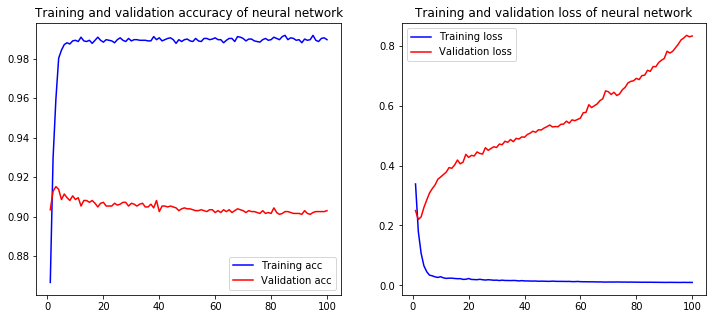

In [50]:
history_nn = model_nn.fit(Xtrain_tfidf, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_tfidf, y_test),
                    batch_size=10)

loss, accuracy = model_nn.evaluate(Xtrain_tfidf, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_nn.evaluate(Xtest_tfidf, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy of neural network')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss of neural network')
    plt.legend()
    plt.show()

plot_history(history_nn)